In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp

#%matplotlib widget

In [2]:
HEADER = ['F3', 'Fz', 'F4', 'FC3', 'FCz', 'FC4', 'C3', 'Cz', 'C4', 'CP3', 'CPz', 'CP4', 'P3', 'Pz', 'P4', 'Oz', 'Photoresistor']
tsv = pd.read_csv("data/S1_21_tomas_3.tsv", sep="\t", names=HEADER)

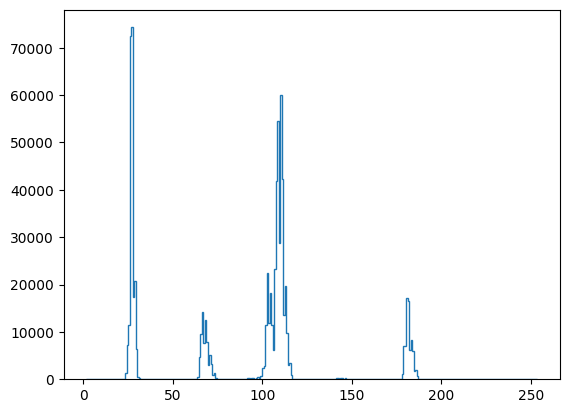

In [3]:
pr = tsv["Photoresistor"].to_numpy()
tsv["Photoresistor"].to_csv("data/photoresistor.csv")

bins, count = np.histogram(pr, bins=300)

plt.close()
plt.stairs(bins, count)
plt.show()

In [4]:

"""
Reading the csv generated by the protocol program, we know that:
- The first action was the right hand
- The right hand option is paired with up (both hands)
- The first reponse was HIGH (so ACTION_2)
- Each action was recorded (15 samples per set) * 5 (set count) * 2 (action + imagined) = 150

Also, through value analysis, values before 5300 and after 745900 shouldn't be used, since they are after the experiment end.

Useful numbers to know:
- Expected n of high samples = low samples = 150 * 2 = 300
- Expected n of rests = n high samples + n low samples = 600
- Expected n of pauses = n sets + 1 = 7
"""
data = tsv.to_numpy()[5300:751200, :].T # Should still be useful to use a numpy instead of dict to faster filter processing
pr = data[len(data)-1]
pr = scp.signal.medfilt(pr, 29)

getfirst = lambda x: np.where(x.astype(int) - np.concatenate([[True], x[:-1]]).astype(int) == 1)[0]
getlast = lambda x: np.where(x.astype(int) - np.concatenate([[False], x[:-1]]).astype(int) == -1)[0]

20


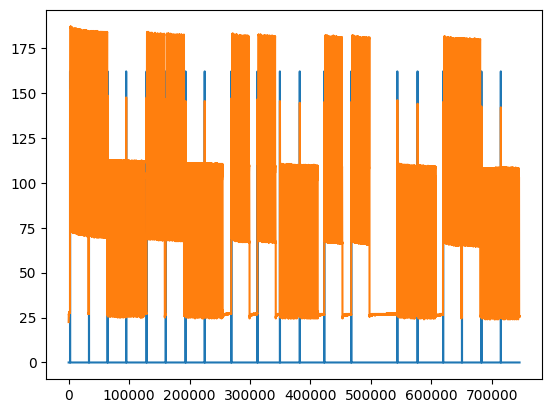

In [5]:
CYAN_MIN = 140
CYAN_MAX = 152

cyan_samples = np.logical_and(pr < CYAN_MAX, pr > CYAN_MIN)
cyan_starts = getfirst(cyan_samples)
cyan_ends = getlast(cyan_samples)

cyan_indexes_wanted = np.where(np.logical_and(pr[cyan_ends + 2] < CYAN_MAX, pr[cyan_starts - 2] < CYAN_MAX))[0]
cyan_starts = cyan_starts[cyan_indexes_wanted]
cyan_ends = cyan_ends[cyan_indexes_wanted]
print(len(cyan_starts))

cyan_plot = np.zeros(pr.shape)
cyan_plot[cyan_starts] = CYAN_MAX + 10
plt.close()
plt.plot(cyan_plot)
plt.plot(pr)
plt.show()

In [6]:
collection_ends = np.concatenate([cyan_starts[1:], [len(pr)]])

task1_indexes = np.array([0, 1, 4, 5, 8, 9, 12, 13, 16, 17])
task2_indexes = task1_indexes + 2

task1_ranges = np.array([cyan_ends[task1_indexes], collection_ends[task1_indexes]]).T
task2_ranges = np.array([cyan_ends[task2_indexes], collection_ends[task2_indexes]]).T

In [7]:
LEFT_MIN = 170

RIGHT_MAX = 77
RIGHT_MIN = 63


right_hand_ranges = []
left_hand_ranges = []

for r in task1_ranges:
	tpr = pr[r[0]:r[1]]

	left_samples = tpr > LEFT_MIN
	left_first = getfirst(left_samples)
	left_last = getlast(left_samples)

	right_samples = np.logical_and(tpr > RIGHT_MIN, tpr < RIGHT_MAX)
	right_first = getfirst(right_samples)
	right_last = getlast(right_samples)
	right_indexes_wanted = np.where(tpr[right_first - 1] > RIGHT_MIN)[0]
	right_first = right_first[right_indexes_wanted[:15]]
	right_last = right_last[right_indexes_wanted[:15]]

	temp_left_ranges = np.array([left_first + r[0], left_last + r[0]]).T
	temp_right_ranges = np.array([right_first + r[0], right_last + r[0]]).T
	left_hand_ranges.append(temp_left_ranges)
	right_hand_ranges.append(temp_right_ranges)


	print(len(left_first), len(left_last), np.average(left_last - left_first), len(right_first), len(right_last), np.average(right_last - right_first))

right_hand_ranges = np.concatenate(right_hand_ranges)
left_hand_ranges = np.concatenate(left_hand_ranges)

15 15 494.3333333333333 15 15 471.53333333333336
15 15 494.73333333333335 15 15 470.1333333333333
15 15 495.26666666666665 15 15 472.6
15 15 495.2 15 15 469.6666666666667
15 15 495.4 15 15 468.4
15 15 495.3333333333333 15 15 466.53333333333336
15 15 495.1333333333333 15 15 471.8666666666667
15 15 495.6666666666667 15 15 472.1333333333333
15 15 495.2 15 15 484.4
15 15 494.8 15 15 471.1333333333333


In [8]:
HANDS_MAX = 106.5
HANDS_MIN = 100

FEET_MAX = 35
FEET_MIN = 23

hand_ranges = []
feet_ranges = []

i = 1
for r in task2_ranges:
	tpr = pr[r[0]:r[1]]

	hands_samples = np.logical_and(tpr > HANDS_MIN, tpr < HANDS_MAX)
	hands_first = getfirst(hands_samples)
	hands_last = getlast(hands_samples)
	if hands_last[0] < hands_first[0]:
		hands_last = hands_last[1:]
	#hands_indexes_wanted = np.where(np.logical_and(tpr[hands_first - 1] > HANDS_MIN, tpr[hands_last + 1] > HANDS_MIN))[0]
	#hands_first = hands_first[hands_indexes_wanted]
	#hands_last = hands_last[hands_indexes_wanted]
	hands_indexes_wanted = np.where(hands_last - hands_first > 100)[0]
	hands_first = hands_first[hands_indexes_wanted]
	hands_last = hands_last[hands_indexes_wanted]

	feet_samples = np.logical_and(tpr > FEET_MIN, tpr < FEET_MAX)
	feet_first = getfirst(feet_samples)
	feet_last = getlast(feet_samples)
	if len(feet_first) > len(feet_last):
		feet_first = feet_first[:len(feet_last)]
	feet_indexes_wanted = np.where(np.logical_and(tpr[feet_first - 1] > FEET_MIN, tpr[feet_last + 1] > FEET_MIN))[0]
	feet_first = feet_first[feet_indexes_wanted[:15]]
	feet_last = feet_last[feet_indexes_wanted[:15]]
	if feet_last[14] - feet_first[14] > 500:
		feet_last[14] = feet_first[14] + 500

	temp_hand_ranges = np.array([left_first + r[0], left_last + r[0]]).T
	temp_feet_ranges = np.array([right_first + r[0], right_last + r[0]]).T
	hand_ranges.append(temp_left_ranges)
	feet_ranges.append(temp_right_ranges)

	# change i to print some run
	if i == 0:
		plt.close()
		HANDS = True
		FEET = not HANDS
		if HANDS:
			hands_plot = np.zeros(tpr.shape)
			hands_plot[hands_first] = HANDS_MAX
			plt.plot(hands_plot)
			hands_plot2 = np.zeros(tpr.shape)
			hands_plot2[hands_last] = HANDS_MAX
			plt.plot(hands_plot2)
		if FEET:
			feet_plot = np.zeros(tpr.shape)
			feet_plot[feet_first] = FEET_MAX
			plt.plot(feet_plot)
			feet_plot2 = np.zeros(tpr.shape)
			feet_plot2[feet_last] = FEET_MAX
			plt.plot(feet_plot2)
		plt.plot(tpr)
		plt.show()
	i += 1

	print(len(hands_first), len(hands_last), np.average(hands_last - hands_first), len(feet_first), len(feet_last), np.average(feet_last - feet_first))

hand_ranges = np.concatenate(hand_ranges)
feet_ranges = np.concatenate(feet_ranges)

15 15 503.6666666666667 15 15 471.4
15 15 505.2 15 15 470.46666666666664
15 15 511.8666666666667 15 15 469.3333333333333
15 15 512.2666666666667 15 15 468.93333333333334
15 15 515.9333333333333 15 15 471.73333333333335
15 15 519.8666666666667 15 15 467.8666666666667
15 15 515.2666666666667 15 15 466.46666666666664
15 15 521.2 15 15 469.26666666666665
15 15 528.8666666666667 15 15 473.26666666666665
15 15 513.8666666666667 15 15 467.6


In [17]:
output = np.array([left_hand_ranges, right_hand_ranges, hand_ranges, feet_ranges])
np.save("segments", output)